In [5]:
!pip install torch
!pip install matplotlib
!pip install numpy
!pip install kagglehub

  Using cached matplotlib-3.10.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.4-cp313-cp313-macosx_10_13_universal2.whl.metadata (106 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached numpy-2.3.0-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pillow-11.2.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp313-cp313-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.58.4-cp313-cp313-macosx_10_13_universal2.whl (2.7 MB)
Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl (65 kB)
Using cached numpy-2

In [121]:
import torch.nn.functional as F
from torch.distributions import Uniform
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import torch
import os
from copy import deepcopy
%matplotlib inline

In [123]:
def download_dataset() -> str:
    path = kagglehub.dataset_download("rishitjakharia/names-txt")
    return path # for easier access later

In [124]:
dataset_path = download_dataset() + "/names.txt"

In [125]:
words = open(dataset_path, 'r').read().splitlines()

In [126]:
def make_int_char_maps() -> tuple[dict, dict]:
  chars = sorted(list(set(''.join(words))))
  ctoi = {c: i + 1 for i, c in enumerate(chars)}
  ctoi['.'] = 0
  itoc = {i: c for c, i in ctoi.items()}
  return ctoi, itoc

In [127]:
ctoi, itoc = make_int_char_maps()

In [128]:
print(itoc)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [129]:
print(ctoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [130]:
vocab_size = len(ctoi)
print(vocab_size)

27


In [131]:
block_size = 8
def build_dataset(inp_words) -> tuple[torch.tensor, torch.tensor]:
  inp, target = [], []
  for w in inp_words: 
    context = [0] * block_size

    for ch in w + '.':
      ix = ctoi[ch]
      inp.append(context)
      target.append(ix)
      context = context[1:] + [ix] # crop and append

  inp = torch.tensor(inp)
  target = torch.tensor(target)
  return inp, target

In [132]:
import random
random.seed(42)

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [135]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itoc[ix.item()] for ix in x), '-->', itoc[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [136]:

class Linear:

  def __init__(self, fan_in, fan_out, bias=True, init_mode='kaiming'):
    init_mode = init_mode.lower()
    if init_mode == 'kaiming':
      self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 #
      self.bias = torch.zeros(fan_out) if bias else None
    elif init_mode == 'xavier':
      distr = torch.sqrt(6 / (fan_in + fan_out)) # -x to x
      uniform_dist = Uniform(-distr, distr)
      self.weight = uniform_dist.sample(fan_in, fan_out)
      self.bias = torch.zeros(fan_out) if bias else None
    elif init_mode == 'glorot':
      fan_avg = (fan_in + fan_out)/2
      distr = torch.sqrt(3/fan_avg)
      uniform_dist = (-distr, distr)
      self.weight = uniform_dist.sample(fan_in, fan_out)
      self.bias = torch.zeros(fan_out) if bias else None
      
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)


  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance, mean of 0, variance of 1
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]
    

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def get_checkpoint(self):
    out_layers = []
    for layer in self.layers:
      print(f"Copying: {layer.__class__.__name__}")
      out_layers.append(deepcopy(layer))
    return Sequential(out_layers)

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
  
  # -----------------------------------------------------------------------------------------------

class Flatten:

  def __call__(self, x):
    s = x.shape[0]
    out = x.view(s, -1)
    if out.shape[1] == 1:
      out = out.squeeze(1)
    self.out = out
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------

class FlattenConsecutive:

  # flatten into feature * n groups
  # (4, 8, 10) , n = 2 , (4, 4, 20)
  def __init__(self, n):
    self.n = n
  
  def __call__(self, x):
    N, L, C = x.shape # batch size, length, feature size
    out  = x.view(N, L // self.n, C * self.n)
    if out.shape[1] == 1:
      out = out.squeeze(1)
    self.out = out
    return self.out

  def parameters(self):
    return []


In [137]:
torch.manual_seed(42) # for reproducibility

In [138]:
no_init = torch.randn(100, 200)
xav = Linear(100, 200, 'xavier')
kai = Linear(100, 200, 'kaiming')
glor = Linear(100, 200, 'glorot')

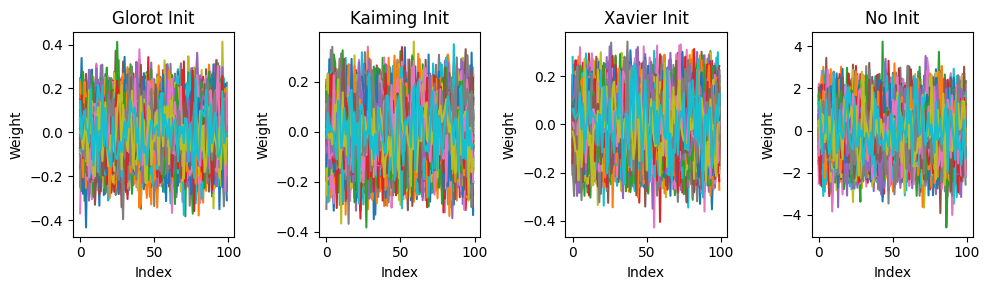

In [165]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3))


axes[0].plot(glor.weight)
axes[0].set_title('Glorot Init')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Weight')

axes[1].plot(kai.weight) 
axes[1].set_title('Kaiming Init')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Weight')

axes[2].plot(xav.weight) 
axes[2].set_title('Xavier Init')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Weight')

axes[3].plot(no_init) 
axes[3].set_title('No Init')
axes[3].set_xlabel('Index')
axes[3].set_ylabel('Weight')


# adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# display the plot
plt.show()

In [170]:
n_emb = 28 # dimensionality of the character vectors
n_hidden = 68 # num hidden layer neurons

C = torch.randn((vocab_size, n_emb))
model=Sequential([
    Embedding(vocab_size, n_emb), 
    FlattenConsecutive(2), Linear(n_emb * 2, n_hidden, False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# make the last layer less confident
with torch.no_grad():
    model.layers[-1].weight *= 0.1

params = model.parameters()
print(f"Num Params: {sum(p.nelement() for p in params)}")
for param in params:
    param.requires_grad = True

Num Params: 25331


In [171]:
#model.get_checkpoint() testing

In [172]:
# we have 8 chars
# 1 2 3 4 5 6 7 8

# (for wavenet) we want to group them by two first 
# (1 2) (3 4) (5 6) (7 8)
# rather than mushing them together in one matrix mult operation with the embeddings

In [173]:
e = torch.randn(4, 8, 10) 
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
implicit = e.view(4, 4, 20) 
torch.equal(explicit, implicit)

True

In [174]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
Xb

tensor([[12,  5,  3, 24,  1, 14,  4,  5],
        [ 0,  0,  0,  0,  0,  0, 10,  1],
        [ 0,  0, 11,  5,  9, 12,  1, 14],
        [ 0,  0,  0,  0,  1, 25, 22,  1]])

In [155]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 28)
FlattenConsecutive : (4, 4, 56)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [156]:
lossi = []
num_epochs = 200_000
batch_size = 64
#min_loss = 2**(31) - 1
#model_checkpoint = None


In [175]:
for i in range(num_epochs):

    ixs = torch.randint(0, Xtr.shape[0], (batch_size,))
    Yb = Ytr[ixs]
    Xb = Xtr[ixs]

    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    for p in params:
        p.grad = None
    loss.backward()

    extr_loss = loss.item()
    lossi.append(extr_loss)

    lr = 0.1
    if i > 125_000:
        lr = 0.01
    elif i > 175_000:
        lr = 0.001
    for p in params:
        p.data += -lr * p.grad

        
    if (i+1) % 10_000 == 0:
        print(f"{i}/{num_epochs}, -> {extr_loss}")

    #if extr_loss < min_loss:
        #min_loss = extr_loss 
        #model_checkpoint = model.get_checkpoint()
        #print(f"New min loss: {min_loss}, model checkpoint saved")




    

9999/200000, -> 2.0889768600463867
19999/200000, -> 2.1596760749816895
29999/200000, -> 1.9947267770767212
39999/200000, -> 2.101370096206665
49999/200000, -> 2.0602684020996094
59999/200000, -> 2.042343854904175
69999/200000, -> 1.837570071220398
79999/200000, -> 1.9166295528411865
89999/200000, -> 2.0385143756866455
99999/200000, -> 1.8187459707260132
109999/200000, -> 1.9254043102264404
119999/200000, -> 1.875342607498169
129999/200000, -> 1.797497272491455
139999/200000, -> 1.8427417278289795
149999/200000, -> 1.8266032934188843
159999/200000, -> 2.1823277473449707
169999/200000, -> 2.3875489234924316
179999/200000, -> 1.9346524477005005
189999/200000, -> 1.7768810987472534
199999/200000, -> 1.8854435682296753


In [176]:
extr_loss

1.8854435682296753

In [178]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

RuntimeError: shape '[-1, 1000]' is invalid for input of size 356691

In [179]:
# to put into eval mode, espeicaly for batch norm
for layer in model.layers:
    layer.training = False

In [180]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train' : (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    x = model(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

In [181]:
split_loss('train')
split_loss('val')

train 1.8465791940689087
val 2.023937940597534


In [205]:
with open("generated_names.txt", 'a') as f:
    names = []
    for _ in range(500):

        out = []
        context = [0] * block_size # all with ...

        while True:

            x = torch.tensor([context])
            x = model(x)
            logits = x
            probs = F.softmax(logits, dim=1)

            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(ix)

            if ix == 0:
                break

        
        name = ''.join(itoc[i] for i in out if itoc[i] != '.')
        names.append(name)

    names.sort()
    f.write('\n'.join(names))


In [206]:
with open("generated_names.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        name = name.split('\n')[0]
        if name in words:
            print(f"{name} exists")
        
